## ResNet Robustness tests

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import time

In [3]:
def get_test_splits(split_n):
    '''
    This function receives a split number split_n and returns
    a dataframe pointing to the test images
    '''
    path = './data/split_'+str(split_n)+'/split_'+str(split_n)+"_"
    test_df = pd.read_csv(path+'test.csv')

    return test_df

In [4]:
test_set_1 = get_test_splits(1)
test_set_2 = get_test_splits(2)
test_set_3 = get_test_splits(3)

In [5]:
def image_reader(dataframe):
    '''
    Takes as input a dataframe pointing to the image files, and returns a 
    dictionary with the test images
    '''
    image_dict = {}
    file_locations = list(dataframe['image_id'])
    labels = list(dataframe['label'])
    category_0 = []
    category_1 = []
    for i in tqdm(range(len(file_locations))):
        image = cv2.imread(file_locations[i]) #, cv2.COLOR_RGB2BGR)
        if labels[i] == 0:
            category_0.append(image)
        else:
            category_1.append(image)

    image_dict[0] = category_0
    image_dict[1] = category_1

    return image_dict

In [6]:
test_images_1 = image_reader(test_set_1)
test_images_2 = image_reader(test_set_2)
test_images_3 = image_reader(test_set_3)

  0%|          | 0/810 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

(224, 224, 3)

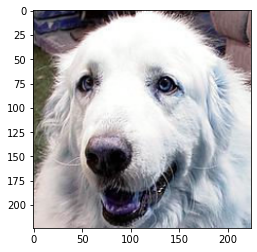

In [7]:
plt.imshow(test_images_1[0][0])
test_images_1[0][0].shape

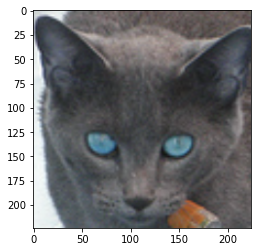

In [7]:
plt.imshow(test_images_1[1][0])

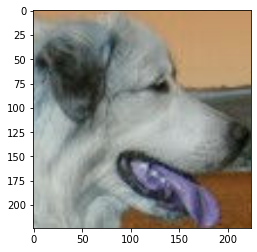

In [8]:
plt.imshow(test_images_2[0][0])

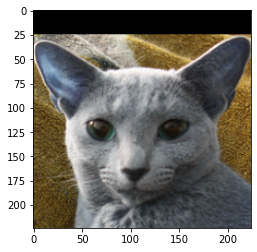

In [9]:
plt.imshow(test_images_2[1][0])

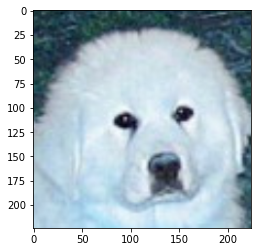

In [10]:
plt.imshow(test_images_3[0][0])

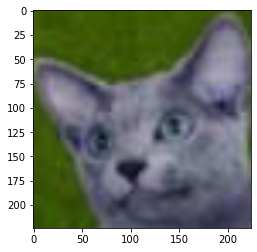

In [11]:
plt.imshow(test_images_3[1][0])

### 5.1 Gaussian pixel noise
To each pixel, to each colour channel, add a Gaussian distributed random number with 10 increas-
ing standard deviations from {0, 2, 4, 6, 8, 10, 12, 14, 16, 18}. Make sure that the pixel values
are integers in the range 0..255 (e.g. replace negative numbers by 0, values > 255 by 255).

In [9]:
from numpy.random import normal, randint

In [59]:
def gaussian_noise(image, std):
    start_time = time.time()
    n_rows, n_columns, n_channels = image.shape
    print(f"Standard deviation: {std}")
    for channel in range(n_channels):
        for row in range(n_rows):
            for column in range(n_columns):
                image[row][column][channel] += normal(loc=0, scale=std)
                if image[row][column][channel] < 0:
                    image[row][column][channel] = 0
                elif image[row][column][channel] > 255:
                    image[row][column][channel] = 255
    end_time = time.time()
    print(f"Image took {end_time-start_time} seconds")
    return image

def gaussian_noise_2(img, std):
    start_time = time.time()
    gauss = normal(0, std, img.shape).astype('uint8')
    img_gauss = cv2.add(img,gauss)
    noisy_img_clipped = np.clip(img_gauss, 0, 255)
    return noisy_img_clipped

In [61]:
stds = np.arange(0, 19, 2)
for std in stds:
    image = np.array(test_images_3[1][0]).copy()
    print(f"Standard deviation: {std}")
    image = gaussian_noise_2(image, std)
    print(image[0][0])

Standard deviation: 0
[65 94  8]
Standard deviation: 2
[65 94  9]
Standard deviation: 4
[ 65 255  14]
Standard deviation: 6
[255 255 255]
Standard deviation: 8
[255 101   8]
Standard deviation: 10
[72 95 11]
Standard deviation: 12
[255 108 238]
Standard deviation: 14
[255 255 255]
Standard deviation: 16
[255  99 255]
Standard deviation: 18
[255 255   8]


### 5.2 Gaussian blurring
Create 10 test images by blurring the original image (in each of the 3 colour channels) by a 3x3 mask:
        [1, 2, 1]
   1/16*[2, 4, 2]
        [1, 2, 1]
Repeatedly  convolve  the  the  image  with  the  mask  0  times,  1  time,  2  times,  ...   9  times.   Thisapproximates Gaussian blurring with increasingly larger standard deviations.

In [62]:
import cv2

In [63]:
def gaussian_blurring(image, n_convs):
    for conv in range(n_convs):
        image = cv2.filter2D(image, -1, kernel)
    return image

In [64]:
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])
kernel = 1/16 * kernel
kernel

array([[0.0625, 0.125 , 0.0625],
       [0.125 , 0.25  , 0.125 ],
       [0.0625, 0.125 , 0.0625]])

Convolved 0 times


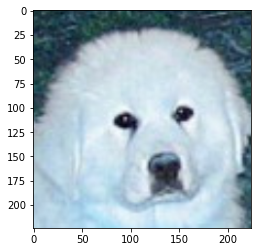

Convolved 1 times


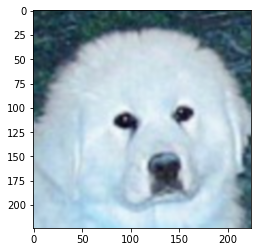

Convolved 2 times


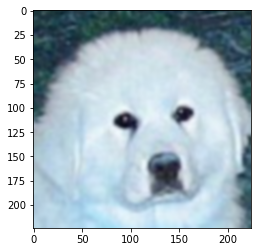

Convolved 3 times


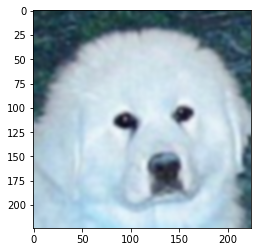

Convolved 4 times


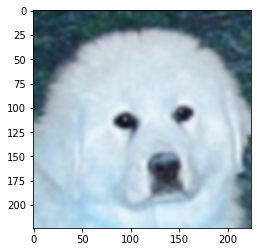

Convolved 5 times


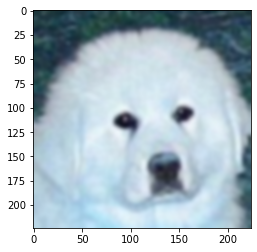

Convolved 6 times


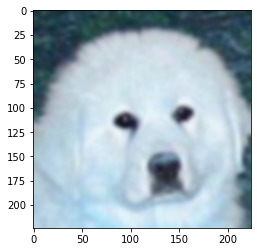

Convolved 7 times


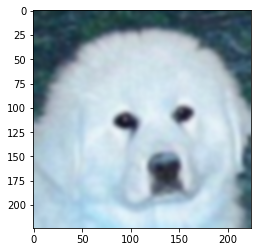

Convolved 8 times


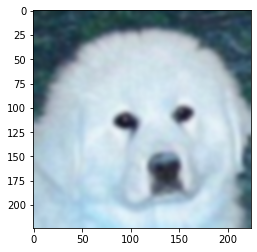

Convolved 9 times


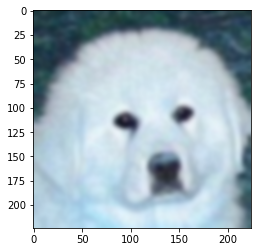

In [65]:
num_convs = np.arange(10)
for n_convs in num_convs:
    image = np.array(test_images_3[0][0]).copy() # This allows us to apply the same convolution to the blurred image
    print(f"Convolved {n_convs} times")
    image = gaussian_blurring(image, n_convs)
    plt.imshow(image)
    plt.show()

### 5.3    Image contrast increase
Create test images by multiplying each channel by {1.0, 1.03, 1.06, 1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27}.  Make sure that the pixel values are integers in the range 0..255 (e.g.replace > 255 values by 255).

In [73]:
def increase_contrast(image, factor):
    start = time.time()
    n_rows, n_columns, n_channels = image.shape
    for channel in range(n_channels):
        image[:, :, channel] = image[:, :, channel] * factor
        for row in range(n_rows):
            for column in range(n_columns):
                if image[row][column][channel] > 255:
                    image[row][column][channel] = 255
    end = time.time()
    print(f"Elapsed time of {end-start}")
    return image

def increase_contrast_2(image, factor):
    n_rows, n_columns, n_channels = image.shape
    for channel in range(n_channels):
        image[:, :, channel] = image[:, :, channel] * factor
    
    image = np.clip(image, 0, 255)
    end = time.time()

    return image

Factor 1.0
Elapsed time of 0.0015993118286132812


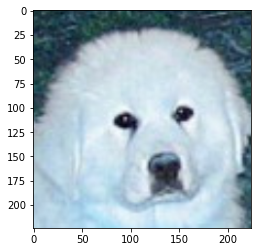

Factor 1.03
Elapsed time of 0.001317739486694336


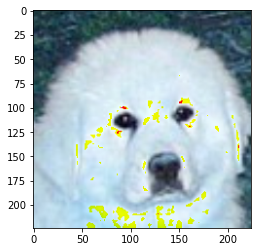

Factor 1.06
Elapsed time of 0.0009660720825195312


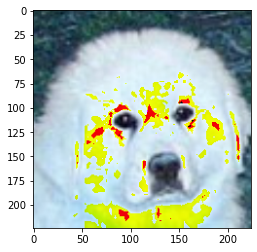

Factor 1.09
Elapsed time of 0.0010480880737304688


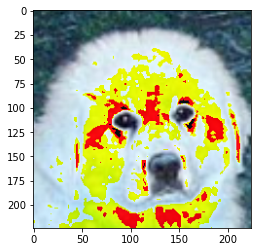

Factor 1.12
Elapsed time of 0.0010733604431152344


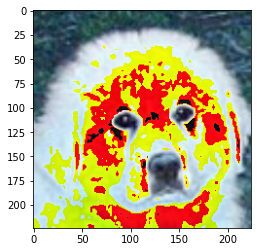

Factor 1.15
Elapsed time of 0.0009121894836425781


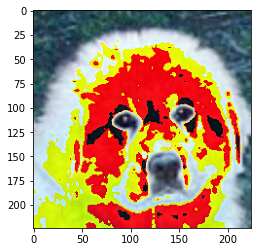

Factor 1.18
Elapsed time of 0.0009319782257080078


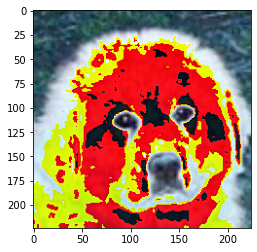

Factor 1.21
Elapsed time of 0.0009899139404296875


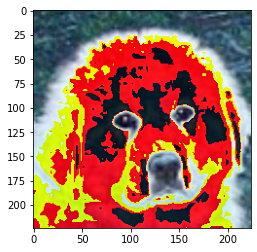

Factor 1.24
Elapsed time of 0.0003895759582519531


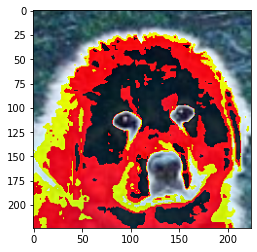

Factor 1.27
Elapsed time of 0.0017082691192626953


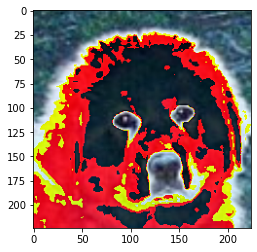

In [74]:
factors = np.linspace(1.0, 1.27, 10)
for factor in factors:
    image = np.array(test_images_3[0][0]).copy()
    print(f"Factor {factor}")
    image = increase_contrast_2(image, factor)
    plt.imshow(image)
    plt.show()

### 5.4    Image contrast decrease
Create test images by multiplying each channel by {1.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30,0.20, 0.10}.

In [77]:
def decrease_contrast(image, factor):
    n_rows, n_columns, n_channels = image.shape
    for channel in range(n_channels):
        image[:, :, channel] = image[:, :, channel] * factor
    return image

Factor 1.0


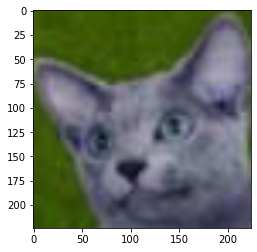

Factor 0.9


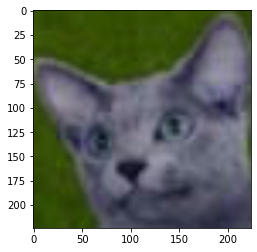

Factor 0.8


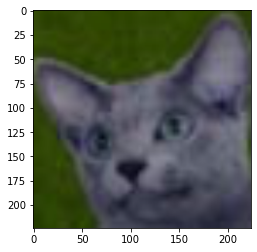

Factor 0.7000000000000001


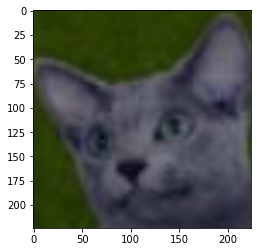

Factor 0.6000000000000001


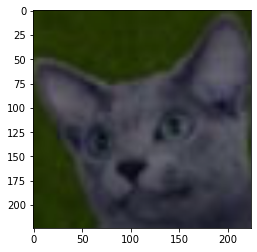

Factor 0.5000000000000001


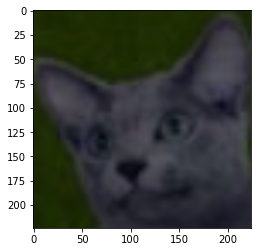

Factor 0.40000000000000013


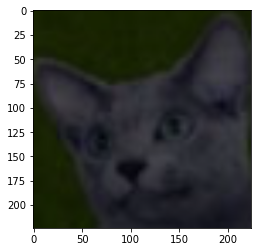

Factor 0.30000000000000016


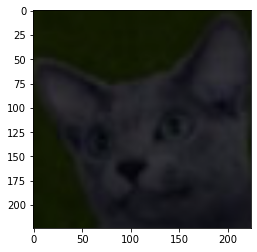

Factor 0.20000000000000018


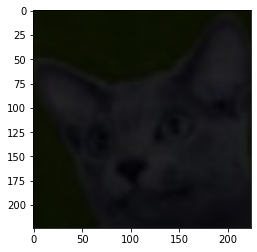

Factor 0.1000000000000002


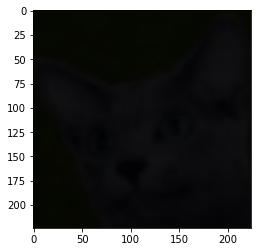

In [78]:
factors = np.arange(1.0, 0.0, -0.1)
for factor in factors:
    image = np.array(test_images_3[1][0]).copy()
    print(f"Factor {factor}")
    image = decrease_contrast(image, factor)
    plt.imshow(image)
    plt.show()

### 5.5 Image brightness increase
Create test images by adding to each channel: {0, 5, 10, 15, 20, 25, 30, 35, 40, 45}.  Make sure that the pixel values are integers in the range 0..255 (e.g. replace > 255 values by 255).

In [19]:
def increase_brighness(image, factor):
    n_rows, n_columns, n_channels = image.shape
    for channel in range(n_channels):
        image[:, :, channel] += factor
    image = np.clip(image, 0, 255)

    return image

Factor 0


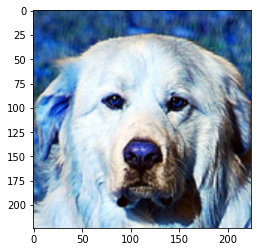

Factor 5


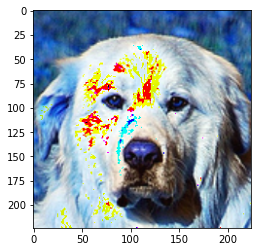

Factor 10


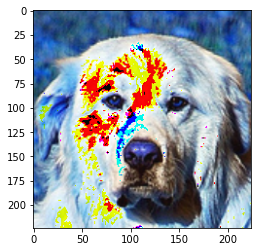

Factor 15


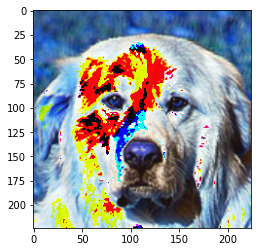

Factor 20


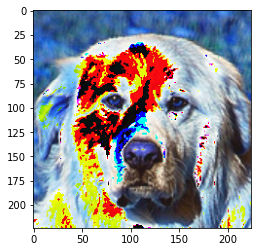

Factor 25


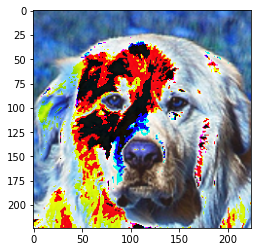

Factor 30


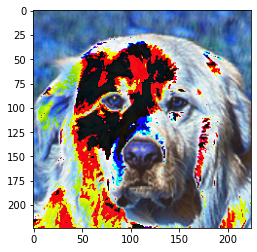

Factor 35


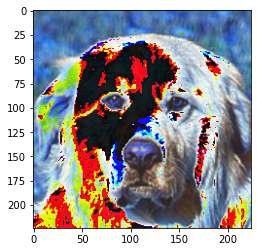

Factor 40


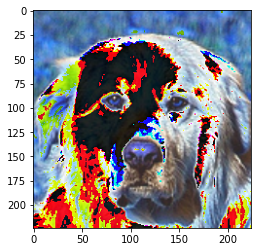

Factor 45


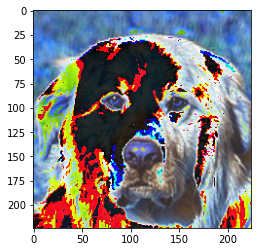

In [20]:
factors = np.arange(0, 50, 5)
for factor in factors:
    image = np.array(test_images_3[0][2]).copy()
    print(f"Factor {factor}")
    image = increase_brighness(image, factor)
    plt.imshow(image)
    plt.show()

### 5.6 Image brightness decrease
Create test images by subtracting from each channel: {0, 5, 10, 15, 20, 25, 30, 35, 40, 45}.  Make sure that the pixel values are integers in the range 0..255 (e.g. replace < 0 values by 0).

In [22]:
def decrease_brightness(image, factor):
    for channel in range(n_channels):
        image[:, :, channel] -= factor
        '''
        for row in range(n_rows):
            for column in range(n_columns):
                if image[row][column][channel] < 255:
                    image[row][column][channel] = 255
        '''
    image = np.clip(image, 0, 255)

    return image

Factor 0


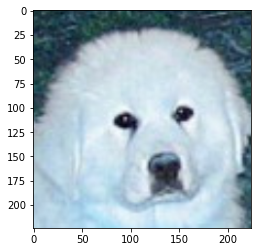

Factor 5


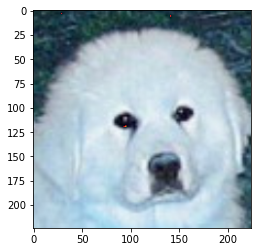

Factor 10


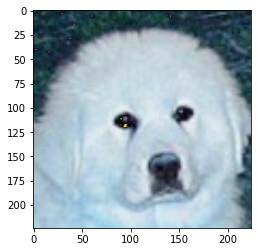

Factor 15


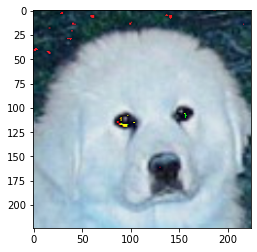

Factor 20


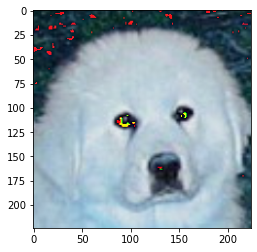

Factor 25


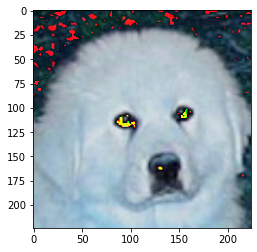

Factor 30


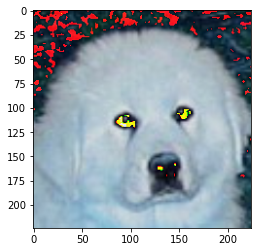

Factor 35


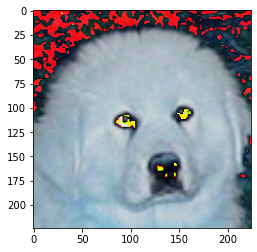

Factor 40


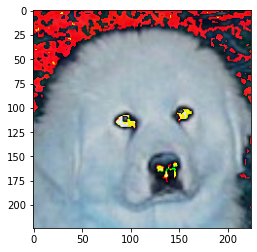

Factor 45


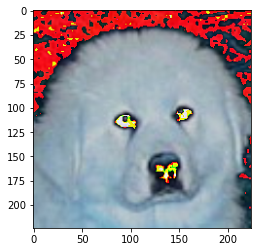

In [23]:
factors = np.arange(0, 50, 5)
for factor in factors:
    image = np.array(test_images_3[0][0]).copy()
    print(f"Factor {factor}")
    n_rows, n_columns, n_channels = image.shape
    image = decrease_brightness(image, factor)
    plt.imshow(image)
    plt.show()

### 5.7    HSV Hue noise increase
Convert the image from RGB to HSV. To the Hue component (assuming a 0..1 scale from yourHSV converter), add Gaussian random noise with zero mean and standard deviation{0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18}.  If the Hue is larger than 1.0, subtract 1.0 to get itback to the 0...1 range.  Convert the image back from HSV to RGB.

In [85]:
def increase_hue_noise(image, std):
    channel = 0
    start = time.time()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    n_rows, n_columns, n_channels = image.shape
    for row in range(n_rows):
        for column in range(n_columns):
            image[row][column][channel] += normal(loc=0, scale=std) * 255
            if image[row][column][channel] < 0:
                image[row][column][channel] = 0
            elif image[row][column][channel] > 255:
                image[row][column][channel] -= 255
    image = np.clip(image, 0, 255)
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    end = time.time()
    print(f"Time elapsed of {end-start}")
    return image

def increase_hue_noise_2(image, std):
    start = time.time()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_noise = normal(0, std, image.shape[:-1])*255
    image[:,:,0] = image[:,:,0] + hue_noise
    image = np.clip(image, 0, 255)
    hued_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    end = time.time()
    return hued_image


Standard deviation: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Time elapsed of 0.004781007766723633


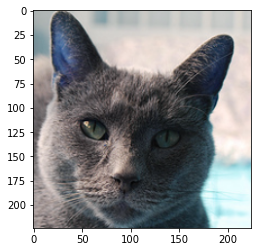

Standard deviation: 0.02
[[ 3.62317221  0.91082639 -2.4923264  ...  3.16103328  2.40921604
   3.4800221 ]
 [-2.48666062  8.40648886 -0.16106162 ... -4.58570272 -0.69149964
  -3.43485618]
 [-2.38393304 -0.86668469 -0.48621191 ...  3.74906004  3.67034286
  -1.45007951]
 ...
 [-2.64945337 10.74966703  5.44497204 ... -6.75261823  3.83491071
  -4.45824657]
 [-4.02010939 -0.83470515 -6.99209914 ...  1.84507131 -1.36916221
  -0.35580609]
 [-2.50555144 -3.46579258 -5.8203395  ...  0.56923597 -5.40477853
   9.60697444]]
Time elapsed of 0.0070154666900634766


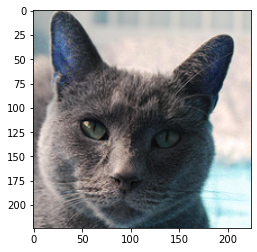

Standard deviation: 0.04
[[  3.04005456  -5.96357469  -5.48700994 ...  -1.67258208  -1.14923359
   10.46938375]
 [  3.06569465   5.97478274 -14.03775318 ...   9.44157953  -8.43722945
   -0.89404168]
 [ -1.80592668 -11.65776845  -8.09528438 ...  -3.92068565  -9.89332658
    6.8813557 ]
 ...
 [  6.30127527  -4.30917444  -0.70311172 ...   2.50563169   1.64947339
    5.09560195]
 [ 10.29272174  -3.75443041   6.24290996 ...  -4.30964357   7.391309
   -7.98898603]
 [ 10.67933742   9.18129248  -4.36198917 ...  -5.12440995  -3.47908915
    2.52738998]]
Time elapsed of 0.008664369583129883


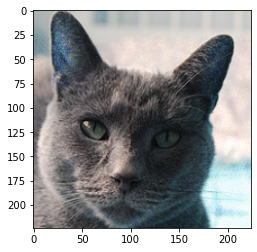

Standard deviation: 0.06
[[ -5.24943053 -18.86736343 -11.7781118  ...  10.73244245 -13.74081297
   11.14047669]
 [  1.3102751   -1.91336864 -17.16284211 ... -13.24262062  -6.43132739
   21.09027146]
 [ 13.01210418   6.25872947  -0.85848924 ... -32.91357756   9.39529735
  -10.61558843]
 ...
 [ -7.09290876  15.85614939 -20.3556194  ...   0.25795024  -0.69460828
   25.86735828]
 [  4.05006109   1.56176064 -18.43870523 ... -12.40684361 -13.28598584
   -9.620114  ]
 [-25.04897588   4.1546683    1.83076038 ...  -2.88347796  29.40832741
    3.11988099]]
Time elapsed of 0.006979227066040039


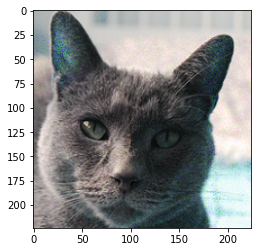

Standard deviation: 0.08
[[ 41.16962264  -1.34527661  23.76097387 ...  -2.5297616    7.91880477
   15.2912914 ]
 [  1.04662562 -18.4000873  -20.17368274 ... -29.65166213 -30.89427553
  -29.17113294]
 [-34.97606446   9.62724711  -7.58052592 ... -17.88432297   5.20452174
  -12.15923496]
 ...
 [  5.2270966  -30.34157594  -1.67751981 ...  -0.40102893 -28.60465702
   26.05913801]
 [ 17.77263757  -1.77389755  -1.47634364 ...  -1.71324537  17.63876177
   30.66713454]
 [ 32.92335611  24.14809655   0.22207551 ...  10.5319323  -30.08690735
  -48.09182112]]
Time elapsed of 0.007071495056152344


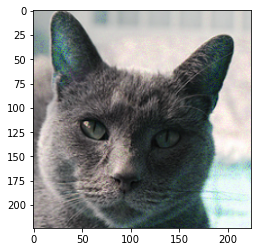

Standard deviation: 0.1
[[ 74.22712572  -3.26463877  16.32081239 ...  20.36319087  18.8349466
    0.23901557]
 [-20.4529548   28.65056683   9.97142542 ...   3.44667722  -4.99947803
   -9.75792175]
 [ 13.12646506   4.79005493  12.33436914 ...  -8.89198845  20.1842013
    4.5056567 ]
 ...
 [ 14.19383711  -1.9056735  -11.57483077 ...  -3.50581622 -15.51983773
  -13.61408409]
 [ 10.86632804  14.11771924   0.61434953 ... -48.89184858  -3.91354581
  -30.87336189]
 [-34.7354882  -26.64297192  34.46898796 ...  -2.29179736  25.42347683
    7.32231746]]
Time elapsed of 0.011473655700683594


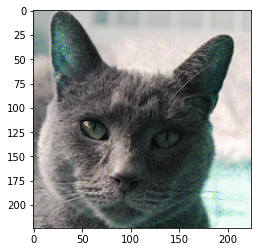

Standard deviation: 0.12
[[-37.79128207 -20.18025358  -4.69794816 ... -26.0582934   12.79863191
  -15.7550009 ]
 [ 27.03496827 -11.84187891  13.51461764 ...  -4.58333676 -28.22154478
   49.46273049]
 [-22.98847358  23.62821924 -39.8604559  ...  29.83313445  16.82962512
  -19.31273812]
 ...
 [ 87.03685299 -58.10764518 -23.14074505 ...  31.38826707 -13.77611323
    8.73705857]
 [-11.6981922  -28.82929856 -12.25608002 ...  -4.91534     62.18311532
   -8.10212075]
 [  3.87434264  -9.51862374   7.38161705 ... -68.94990221 -16.60942386
  -27.064928  ]]
Time elapsed of 0.00734257698059082


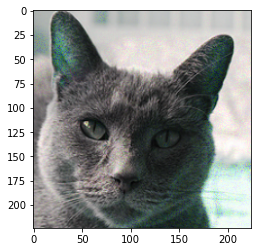

Standard deviation: 0.14
[[-133.36952066   42.84745197   -4.97929091 ...   36.79700673
   -47.42521213    9.7052346 ]
 [  12.23698625  -77.76940507  -13.27649614 ...  -17.26815161
    34.2228859   -11.59249805]
 [ -42.04980204  -24.47190854    1.69200174 ...  -37.75469544
   -19.43046145   -2.53740011]
 ...
 [   8.50059948  -16.29201811   -6.25022827 ...   26.27894429
    31.83878001   16.44159823]
 [ -11.57934016   59.17692869  -49.50039411 ...  -35.96602157
   -32.62179826   10.51316097]
 [  31.24718919   60.28365184  -15.82823856 ...    9.48381367
   -10.58285065    5.06288377]]
Time elapsed of 0.010849952697753906


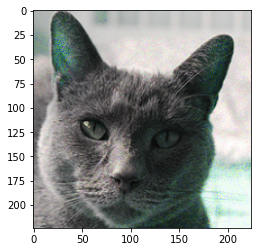

Standard deviation: 0.16
[[-37.10173088  35.25824122  48.14692461 ... -19.790948   -10.09624987
  -31.79016606]
 [-77.73672607 -21.83690764 -29.05286734 ... -21.73311142 -12.52887081
   62.09579824]
 [  3.04675656  -8.95819116  -2.7720201  ... -32.57251659 -23.78279308
   35.14544524]
 ...
 [ 44.14461194  76.85533925  23.4036098  ...  12.28041192  27.27328117
    6.78806374]
 [-71.30104988  13.29966919  65.41628117 ...  43.46429829  60.76101263
    3.16222515]
 [ 54.27883748  91.99129977  42.34456939 ... -61.55098833  10.57713602
  -10.75476275]]
Time elapsed of 0.01534581184387207


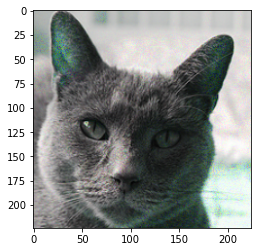

Standard deviation: 0.18
[[  17.95436238   -8.42769269   26.3316484  ...   21.86464017
    43.07348873   16.164836  ]
 [ -37.5546499   -79.84530066  -15.18279148 ...   10.51086002
    -0.70682856  -81.99902432]
 [ -34.68697378   60.27208008    2.92516073 ...  -51.87264204
    38.84221296   -7.54988707]
 ...
 [  -1.66723159  -36.91059496   23.03432923 ...  -30.56423454
    -3.2185256  -118.64059352]
 [  25.88629622   71.89460041   19.8655111  ...   -3.94651833
   -78.18545488  -11.67343283]
 [  82.87165007   63.92682642   13.48164266 ...  -28.09590215
    28.13085675   95.31020751]]
Time elapsed of 0.0068209171295166016


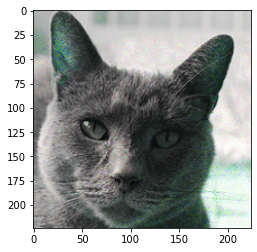

In [86]:
stds = np.arange(0.0, 0.19, .02)
for std in stds:
    image = np.array(test_images_3[1][2]).copy()
    print(f"Standard deviation: {std}")
    image = increase_hue_noise_2(image, std)
    plt.imshow(image)
    plt.show()

In [63]:
test_images_3[1][0].shape[:2]

(224, 224)

### 5.8    HSV Saturation noise increase
Convert the image from RGB to HSV. To the Saturation component (assuming a 0..1 scale fromyour HSV converter), add Gaussian random noise with zero mean and standard deviation{0.00,0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18}.  If the Saturation is larger than 1.0, clip to 1.0.Alternatively, if the Saturation is less than 0.0, then reset the Saturation to 0.  Convert the imageback from HSV to RGB.

In [89]:
def increase_saturation_noise(image, std):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    n_rows, n_columns, n_channels = image.shape
    for row in range(n_rows):
        for column in range(n_columns):
            image[row][column][channel] += normal(loc=0, scale=std) * 255
            if image[row][column][channel] < 0:
                image[row][column][channel] = 0
            elif image[row][column][channel] > 255:
                image[row][column][channel] = 255
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def increase_saturation_noise_2(image, std):
    start = time.time()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sat_noise = normal(0, std, image.shape[:-1])*255
    image[:,:,1] = image[:,:,1] + sat_noise
    image = np.clip(image, 0, 255)
    sat_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    end = time.time()
    return sat_image

Standard deviation: 0.0


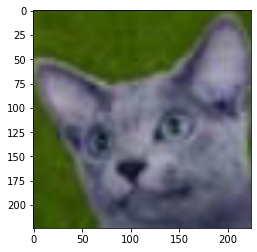

Standard deviation: 0.02


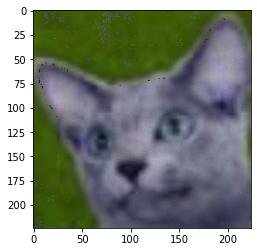

Standard deviation: 0.04


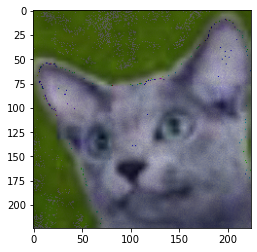

Standard deviation: 0.06


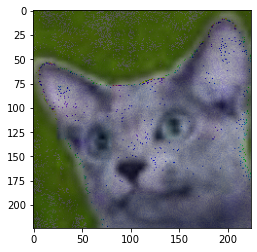

Standard deviation: 0.08


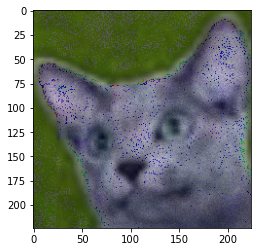

Standard deviation: 0.1


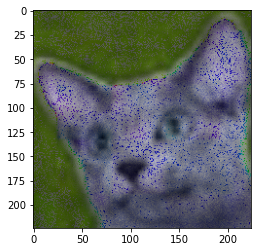

Standard deviation: 0.12


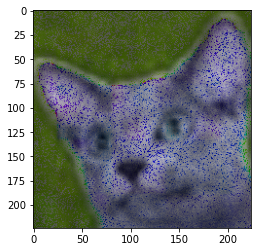

Standard deviation: 0.14


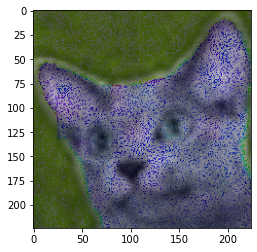

Standard deviation: 0.16


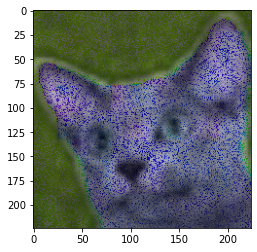

Standard deviation: 0.18


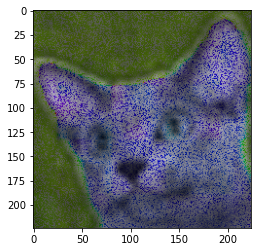

In [90]:
stds = np.arange(0.0, 0.19, .02)
channel = 1
for std in stds:
    image = np.array(test_images_3[1][0]).copy()
    print(f"Standard deviation: {std}")
    image = increase_saturation_noise_2(image, std)
    plt.imshow(image)
    plt.show()

### 5.9    Occlusion of the image increase
In  each  test  image,  replace  a  randomly  placed  square  region  of  the  image  by  black  pixels  with square edge length of {0, 5, 10, 15, 20, 25, 30, 35, 40, 45}.

In [68]:
def image_occlusion(image, edge, print_center=False):
    _rows, n_columns, _ = image.shape
    center = np.array([randint(0, n_rows+1), randint(0, n_columns+1)])
    start_point = center - edge // 2
    start_point = tuple((start_point[0], start_point[1]))
    end_point = center + edge // 2
    end_point = tuple((end_point[0], end_point[1]))
    colour = (0, 0, 0) 
    thickness = -1
    if print_center:
        print(f"Center of the square: [{center[0]}, {center[1]}]")
    image = cv2.rectangle(image, start_point, end_point, colour, thickness)
    return image

Edge size: 0
Center of the square: [141, 46]


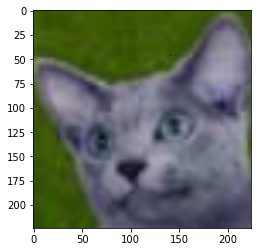

Edge size: 5
Center of the square: [156, 139]


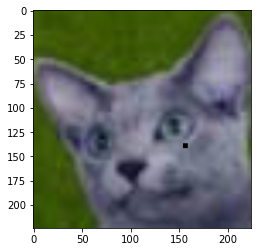

Edge size: 10
Center of the square: [85, 6]


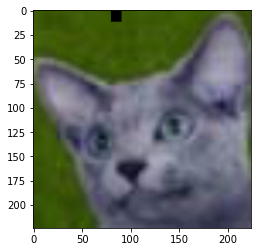

Edge size: 15
Center of the square: [152, 154]


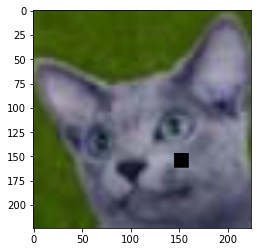

Edge size: 20
Center of the square: [49, 26]


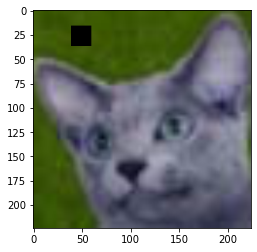

Edge size: 25
Center of the square: [118, 210]


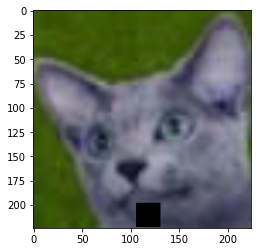

Edge size: 30
Center of the square: [150, 3]


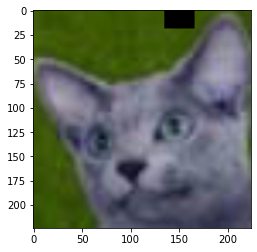

Edge size: 35
Center of the square: [8, 17]


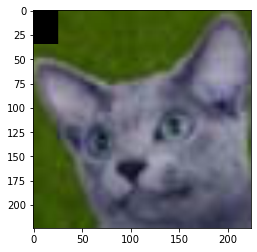

Edge size: 40
Center of the square: [177, 118]


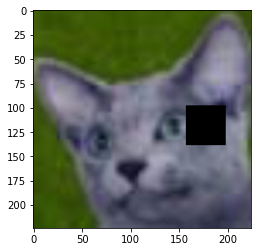

Edge size: 45
Center of the square: [204, 16]


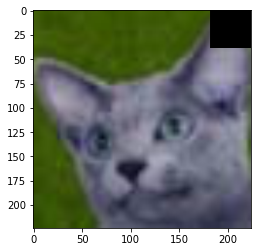

In [69]:
edges = np.arange(0, 50, 5)
for edge in edges:
    image = np.array(test_images_3[1][0]).copy()
    print(f"Edge size: {edge}")
    image = image_occlusion(image, edge, print_center=True)
    
    plt.imshow(image)
    plt.show()